<a href="https://colab.research.google.com/github/soumya0422/FitPulse-Health-Anomaly-Detection-from-Fitness-Devices-/blob/main/anomaly_detection_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from prophet import Prophet

# Load processed features and original dataset
# The path below is to a directory, not a CSV file, which caused the IsADirectoryError.
# Please provide the full path to the actual CSV file you want to load from this directory.
# features = pd.read_csv("/content/drive/MyDrive/FitPulse Health Anomaly Detection")
features = pd.read_csv("/content/drive/MyDrive/FitPulse Health Anomaly Detection/Milestone2/data/extracted_features.csv") # Placeholder: Replace 'features_data.csv' with your actual CSV file name
df = pd.read_csv("/content/drive/MyDrive/processed_data.csv", parse_dates=["Time"])

print("Features shape:", features.shape)
print("Original dataset shape:", df.shape)


Features shape: (14, 1978)
Original dataset shape: (6034, 8)


In [7]:
# Scale features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
features["kmeans_cluster"] = clusters

# Silhouette Score
sil_score = silhouette_score(X_scaled, clusters)
print("KMeans Silhouette Score:", sil_score)

# Distance from cluster center (for anomaly scoring)
distances = np.linalg.norm(X_scaled - kmeans.cluster_centers_[clusters], axis=1)
features["distance_from_center"] = distances


KMeans Silhouette Score: 0.13504137718332757


In [9]:
# Aggregate heart_rate per time for trend modeling
prophet_df = df.groupby("Time", as_index=False).agg(y=("heart_rate", "mean")).rename(columns={"Time": "ds"})

# Remove timezone information from 'ds' column as Prophet does not support it
prophet_df["ds"] = prophet_df["ds"].dt.tz_localize(None)

# Fit Prophet model
model = Prophet(daily_seasonality=True, weekly_seasonality=True)
model.fit(prophet_df)

# Predict trend
future = model.make_future_dataframe(periods=0, freq="h")
forecast = model.predict(future)

# Compute residuals
prophet_df = prophet_df.merge(forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]], on="ds")
prophet_df["residual"] = prophet_df["y"] - prophet_df["yhat"]

# Flag anomalies based on confidence intervals
prophet_df["anomaly_prophet"] = ((prophet_df["y"] > prophet_df["yhat_upper"]) | (prophet_df["y"] < prophet_df["yhat_lower"])).astype(int)

print("Detected anomalies from Prophet:", prophet_df["anomaly_prophet"].sum())


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Detected anomalies from Prophet: 142


In [10]:
# Optional: define anomaly threshold (top 5% farthest points from cluster center)
threshold = np.percentile(features["distance_from_center"], 95)
features["anomaly_cluster"] = (features["distance_from_center"] > threshold).astype(int)

print("Detected anomalies from clustering:", features["anomaly_cluster"].sum())


Detected anomalies from clustering: 1


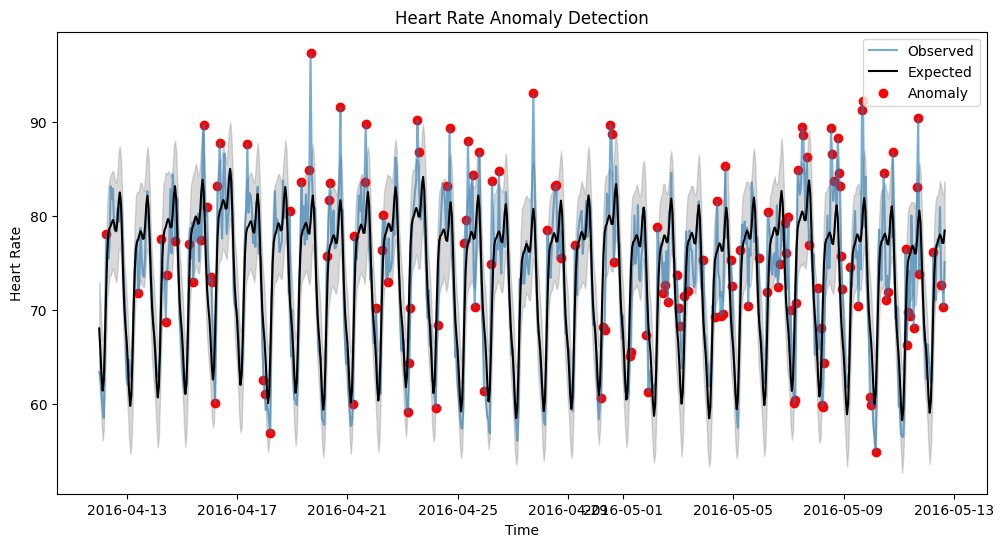

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(prophet_df["ds"], prophet_df["y"], label="Observed", alpha=0.6)
plt.plot(prophet_df["ds"], prophet_df["yhat"], label="Expected", color="black")
plt.fill_between(prophet_df["ds"], prophet_df["yhat_lower"], prophet_df["yhat_upper"], color="gray", alpha=0.3)

# Highlight anomalies
anomalies = prophet_df[prophet_df["anomaly_prophet"] == 1]
plt.scatter(anomalies["ds"], anomalies["y"], color="red", label="Anomaly")

plt.xlabel("Time")
plt.ylabel("Heart Rate")
plt.title("Heart Rate Anomaly Detection")
plt.legend()
plt.show()


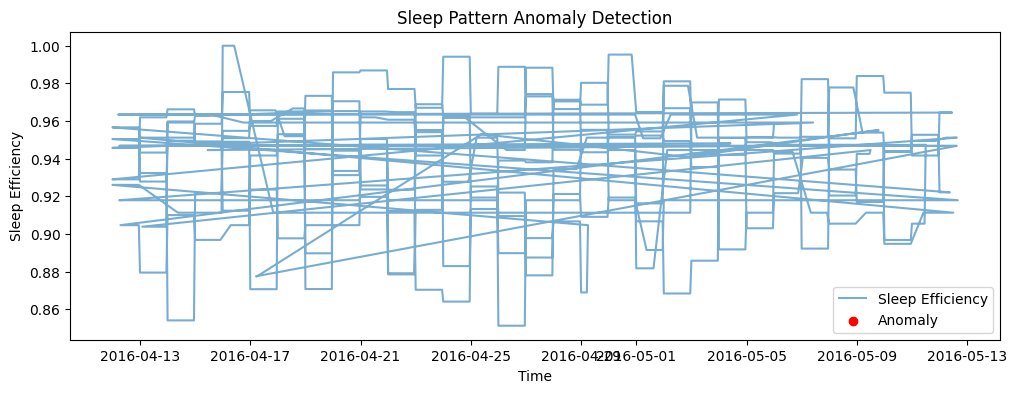

In [12]:
# Example using sleep efficiency
df["sleep_anomaly"] = (df["sleep_efficiency"] < 0.7).astype(int)  # Threshold can be adjusted

plt.figure(figsize=(12, 4))
plt.plot(df["Time"], df["sleep_efficiency"], label="Sleep Efficiency", alpha=0.6)
plt.scatter(df.loc[df["sleep_anomaly"]==1, "Time"], df.loc[df["sleep_anomaly"]==1, "sleep_efficiency"],
            color="red", label="Anomaly")
plt.xlabel("Time")
plt.ylabel("Sleep Efficiency")
plt.title("Sleep Pattern Anomaly Detection")
plt.legend()
plt.show()


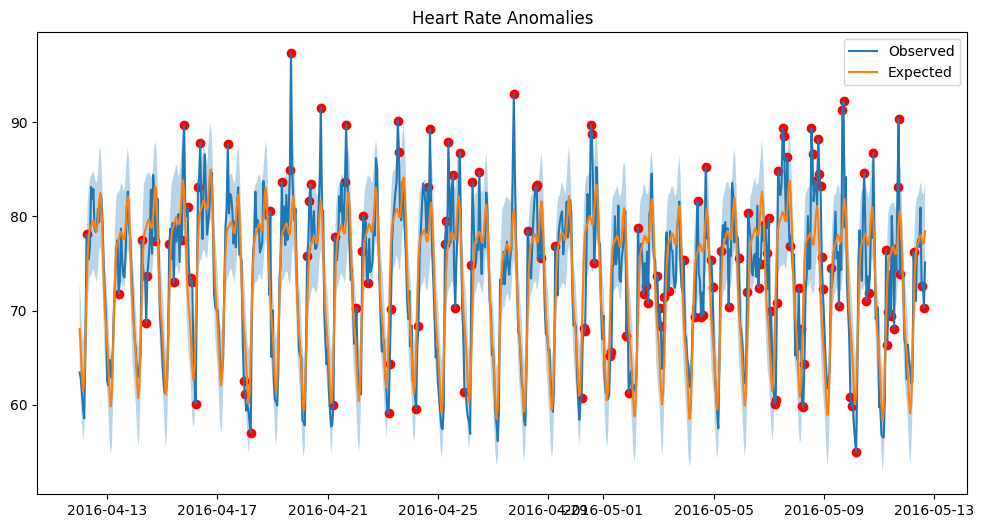

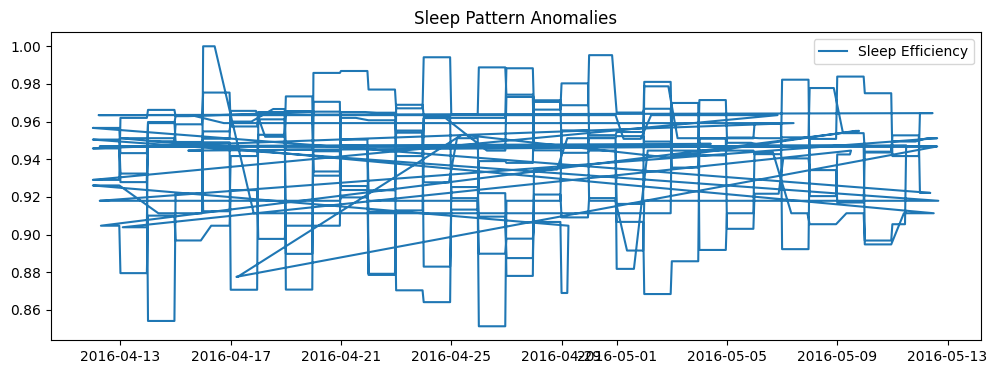

In [14]:
# Create visualizations folder
import os
os.makedirs("visualizations", exist_ok=True)
os.makedirs("data", exist_ok=True)

# Save figures
plt.figure(figsize=(12, 6))
plt.plot(prophet_df["ds"], prophet_df["y"], label="Observed")
plt.plot(prophet_df["ds"], prophet_df["yhat"], label="Expected")
plt.fill_between(prophet_df["ds"], prophet_df["yhat_lower"], prophet_df["yhat_upper"], alpha=0.3)
plt.scatter(anomalies["ds"], anomalies["y"], color="red")
plt.legend()
plt.title("Heart Rate Anomalies")
plt.savefig("visualizations/heart_rate_anomalies.png")

# Save sleep anomalies
plt.figure(figsize=(12, 4))
plt.plot(df["Time"], df["sleep_efficiency"], label="Sleep Efficiency")
plt.scatter(df.loc[df["sleep_anomaly"]==1, "Time"], df.loc[df["sleep_anomaly"]==1, "sleep_efficiency"], color="red")
plt.legend()
plt.title("Sleep Pattern Anomalies")
plt.savefig("visualizations/sleep_anomalies.png")

# Save labeled datasets
features.to_csv("data/behavioral_features_with_anomalies.csv", index=False)
prophet_df.to_csv("data/heart_rate_trends_with_anomalies.csv", index=False)
